# Tarea 2: Comparación de modelos

### Marcelino Sánchez Rodríguez
### 6 de marzo de 2023

In [198]:
# Load necessary packages
library(rstan)
library(coda)
library(R2jags)
library(methods)

# set the working directory

setwd("/home/rstudio/tarea2RegAvanz")

#--- Funciones utiles ---
prob<-function(x){
  out<-min(length(x[x>0])/length(x),length(x[x<0])/length(x))
  out
}

source("/home/rstudio/tarea2RegAvanz/claseNietor6.R")


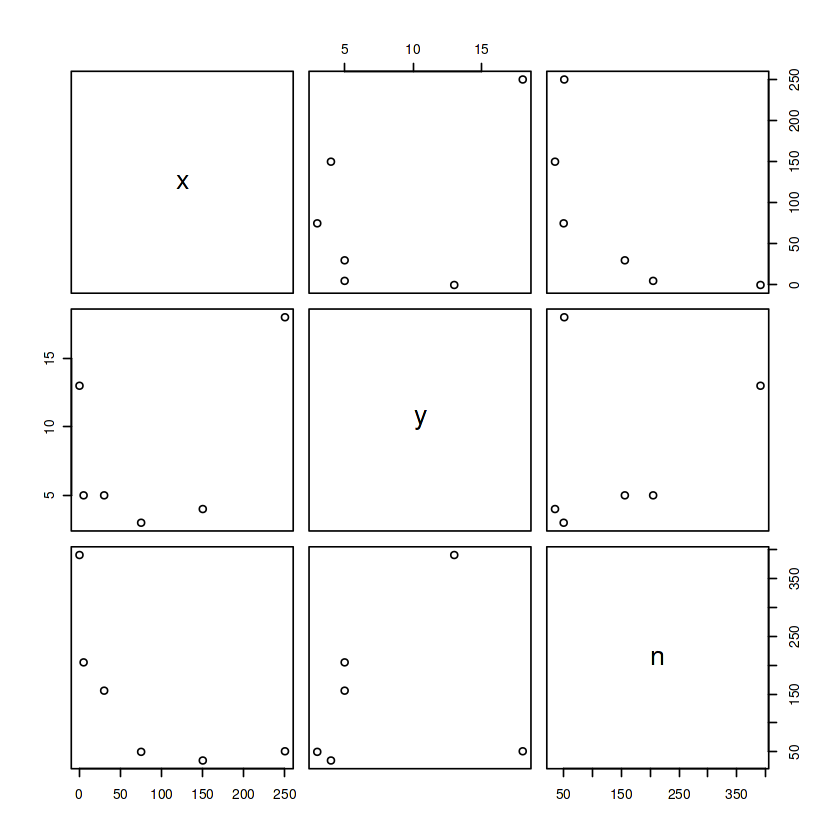

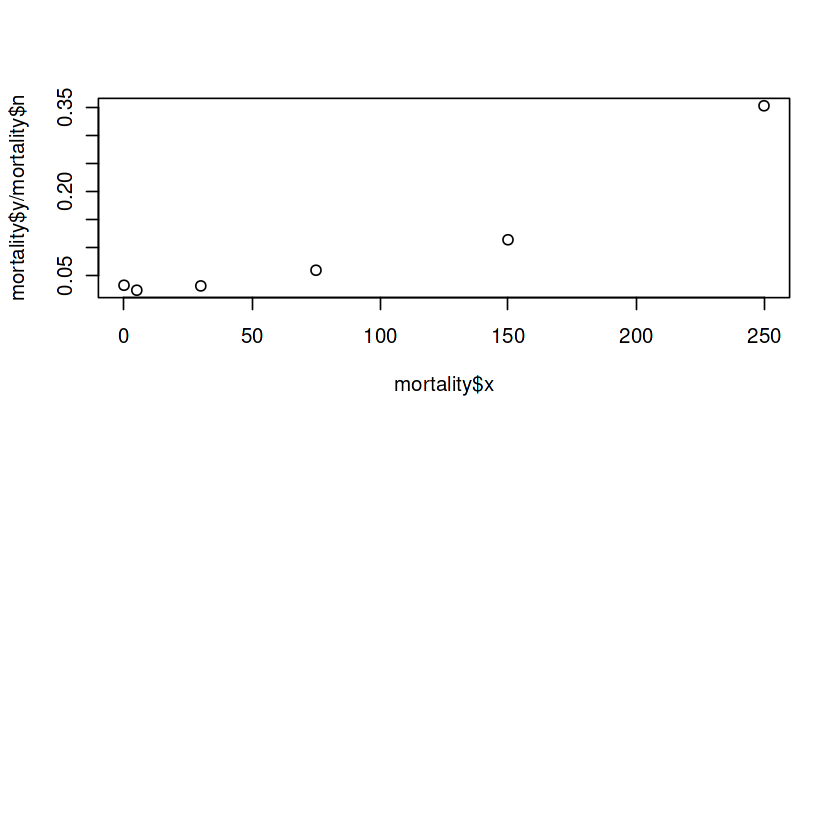

In [180]:
mortality<-read.table("http://gente.itam.mx/lnieto/index_archivos/mortality.txt",header=TRUE)
n<-nrow(mortality)

#creamos gráficas de los datos de mortalidad
par(mfrow = c(2, 1))
plot(mortality)
plot(mortality$x,mortality$y/mortality$n)
m<-1
nef<-c(100)
xf<-c(200)

In [181]:
#-Defining data-
data<-list("n"=n,"ne"=mortality$n,"y"=mortality$y,"x"=mortality$x,"m"=m,"nef"=nef,"xf"=xf)
data2<-list("n"=n,"y"=mortality$y/mortality$n,"x"=mortality$x,"m"=m,"xf"=xf)

#-Defining inits-
inits<-function(){list(beta=rep(0,2),yf1=rep(1,n),yf2=1)}
inits2<-function(){list(beta=rep(0,2),phy=1,yf1=rep(1,n),yf2=1)}

#-Selecting parameters to monitor-
parsa<-c("beta","lambda","yf1","yf2")
parsbc<-c("beta","p","yf1","yf2")
parsd<-c("beta","phy","yf1","yf2")

## Primer modelo

Modelo

$y_{i}|\mu_{i} \sim \text{Poisson}(\mu_{i})$

Relación

$\mu_{i}=\text{n}_{i}\lambda_{i}$

Liga

$\text{log}(\lambda_{i})=\beta_{1}+\beta_{2}*x_{i}$

Priors

$\beta_{j} \sim \text{Norm}(0,0.001)$

In [182]:
#corremos código


modelCode1 <- 'model
{
#Likelihood
for (i in 1:n) {
	y[i] ~ dpois(mu[i])
	mu[i]<-ne[i]*lambda[i]
	log(lambda[i])<-beta[1]+beta[2]*x[i]
	}
#Priors 
for (j in 1:2) { beta[j] ~ dnorm(0,0.001) }
#Prediction 1
for (i in 1:n) { yf1[i] ~ dpois(mu[i]) }
#Prediction 2
#for (i in 1:m) { 
#	yf2[i] ~ dpois(muf[i]) 
#	muf[i]<-nef[i]*lambdaf[i]
#	log(lambdaf[i])<-beta[1]+beta[2]*xf[i]
#}
	yf2 ~ dpois(muf) 
	muf<-nef*lambdaf
	log(lambdaf)<-beta[1]+beta[2]*xf

}'

ej5a.sim <- jagsModel$new(data, inits, parsa, modelCode1,n.thin=1, n.iter=50000, n.burnin=5000)

ej5a.sim$runJagsModel()

Warning message in jags.model(model.file, data = data, inits = init.values, n.chains = n.chains, :
“Unused variable "m" in data”


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 6
   Unobserved stochastic nodes: 9
   Total graph size: 60

Initializing model



## Verificamos convergencia

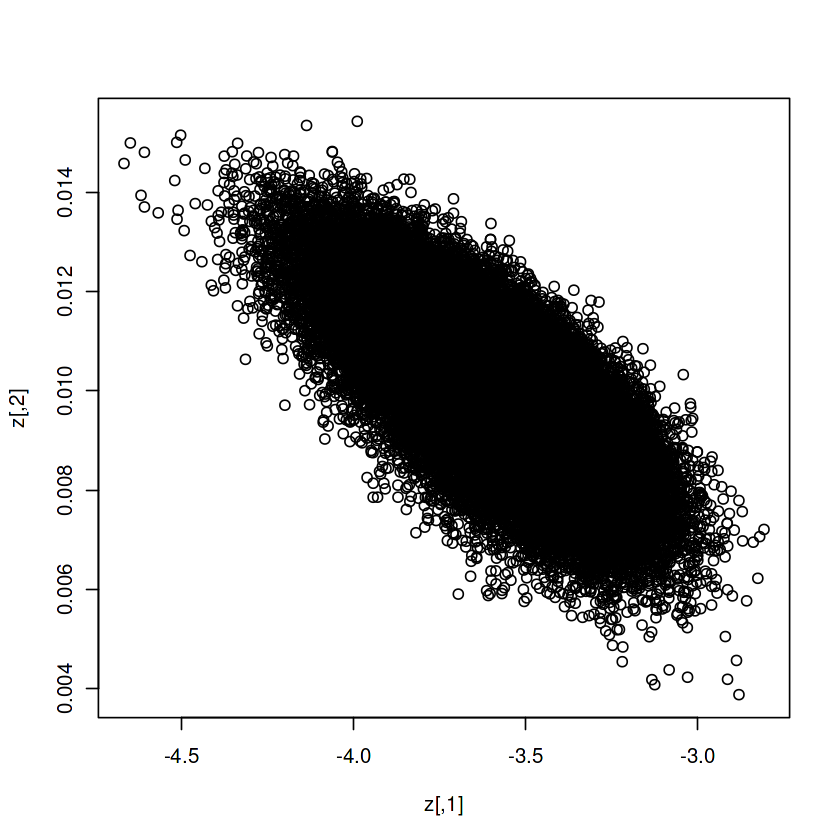

                 mean          sd         2.5%          25%         50%
beta[1]   -3.59171082 0.209293556 -4.020803480 -3.728973704 -3.58567938
beta[2]    0.01001799 0.001308178  0.007422352  0.009140835  0.01002010
deviance  25.12585017 2.013192961 23.170263100 23.699554323 24.50588617
lambda[1]  0.02815289 0.005836002  0.017938546  0.024017472  0.02771783
lambda[2]  0.02957109 0.005993504  0.019043548  0.025333899  0.02913696
lambda[3]  0.03783236 0.006864972  0.025580562  0.033019101  0.03740617
lambda[4]  0.05910237 0.009082728  0.042584524  0.052773547  0.05863391
lambda[5]  0.12525147 0.018993065  0.090549657  0.112014393  0.12440166
lambda[6]  0.34597251 0.078278472  0.209613286  0.290390001  0.34017405
yf1[1]    11.00883333 4.022840567  4.000000000  8.000000000 11.00000000
yf1[2]     6.07067778 2.743353472  1.000000000  4.000000000  6.00000000
yf1[3]     5.90366667 2.655852748  1.000000000  4.000000000  6.00000000
yf1[4]     2.95682222 1.782923286  0.000000000  2.000000000  3.0

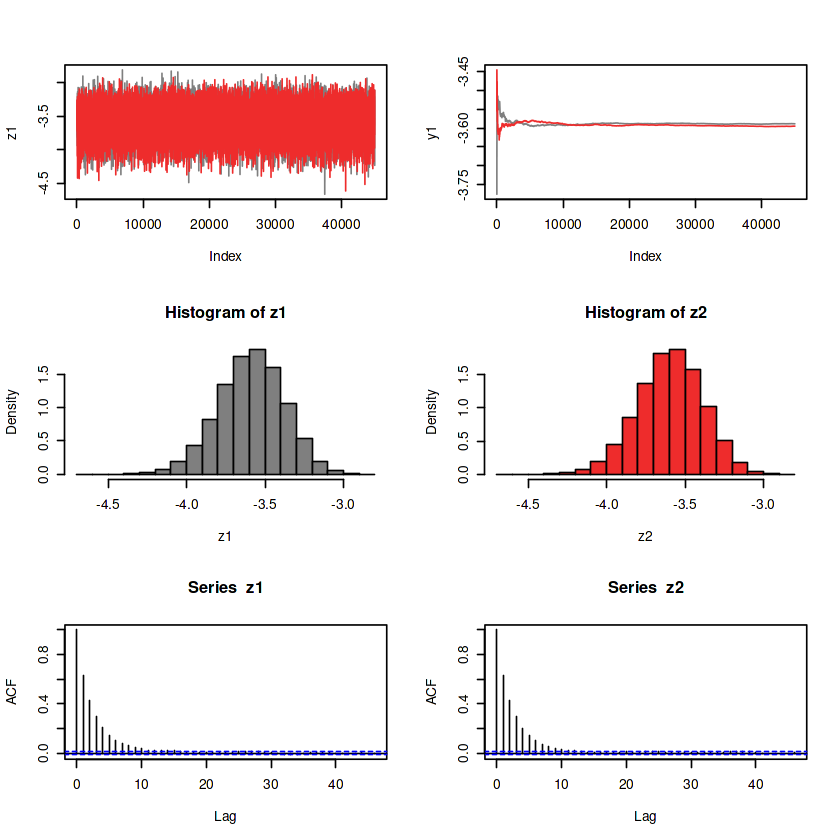

In [183]:
ej5a.sim$viewSpace()

ej5a.sim$graphConvergence()

ej5a.sim$summaryModel()

ej5a.sim$dicModelfunc()

## Checamos intervalos de predicción

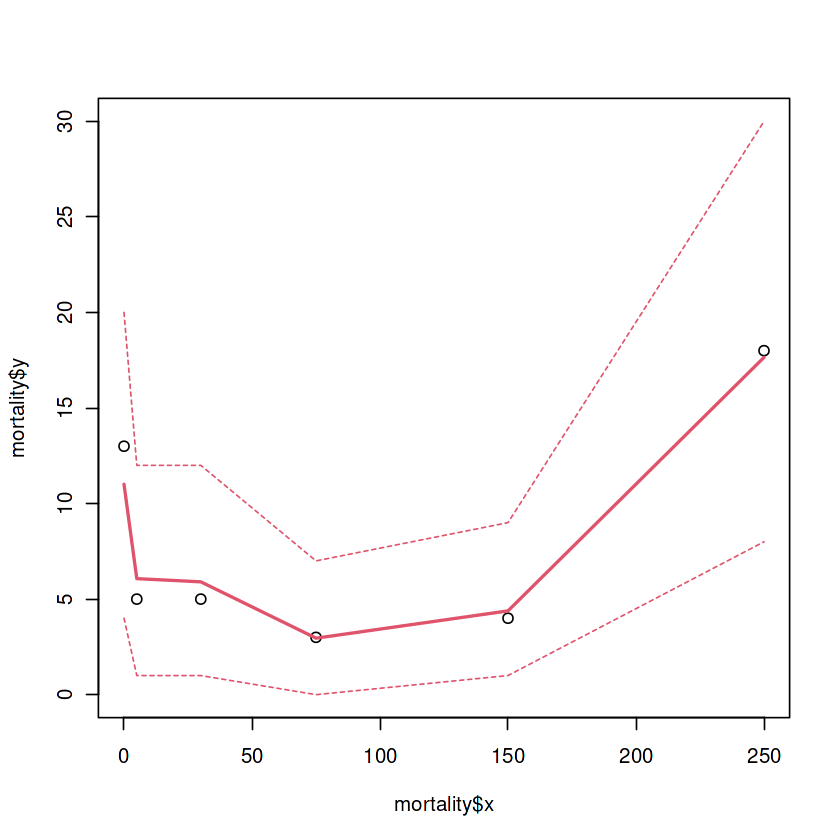

In [200]:
canvaMortalidad()

mortalidadGraf(ej5a.sim,col=2)

## Segundo modelo (logística)

Modelo

$y_{i}|\mu_{i} \sim \text{Bin}(\text{n}_{i},\text{p}_{i})$

Relación

$\mu_{i}=\text{n}_{i}\text{p}_{i}$

Liga logística

$\text{logit}(\text{p}_{i})=\beta_{1}+\beta_{2}*x_{i}$

Priors

$\beta_{j} \sim \text{Norm}(0,0.001)$

In [201]:
#corremos código
modelCode2 <- 'model
{
#Likelihood
for (i in 1:n) {
	y[i] ~ dbin(p[i],ne[i])
	mu[i]<-ne[i]*p[i]
#Liga logistica
	logit(p[i])<-beta[1]+beta[2]*x[i]
#	eta[i]<-beta[1]+beta[2]*x[i]
#	p[i]<-exp(eta[i])/(1+exp(eta[i]))
#Liga probit
#	p[i]<-phi(beta[1]+beta[2]*x[i])
#Liga log-log
#	eta[i]<-beta[1]+beta[2]*x[i]
#	p[i]<-exp(-exp(eta[i]))
#Liga clog-log
#	cloglog(p[i])<-beta[1]+beta[2]*x[i]
	}
#Priors 
for (j in 1:2) { beta[j] ~ dnorm(0,0.001) }
#Prediction 1
for (i in 1:n) { yf1[i] ~ dbin(p[i],ne[i]) }
#Prediction 2
#for (i in 1:m) { 
#	yf2[i] ~ dbin(pf[i],nef[i]) 
#	muf[i]<-nef[i]*pf[i]
#	logit(pf[i])<-beta[1]+beta[2]*xf[i]
#}
	yf2 ~ dbin(pf,nef) 
	muf<-nef*pf
#	logit(pf)<-beta[1]+beta[2]*xf
#	pf<-phi(beta[1]+beta[2]*xf)
#	etaf<-beta[1]+beta[2]*xf
#	pf<-exp(-exp(etaf))
	cloglog(pf)<-beta[1]+beta[2]*xf	
}'

ej5b.sim <- jagsModel$new(data, inits, parsbc, modelCode2, n.thin=1, n.iter=50000, n.burnin=5000)

ej5b.sim$runJagsModel()



Warning message in jags.model(model.file, data = data, inits = init.values, n.chains = n.chains, :
“Unused variable "m" in data”


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 6
   Unobserved stochastic nodes: 9
   Total graph size: 60

Initializing model



## Verificamos convergencia

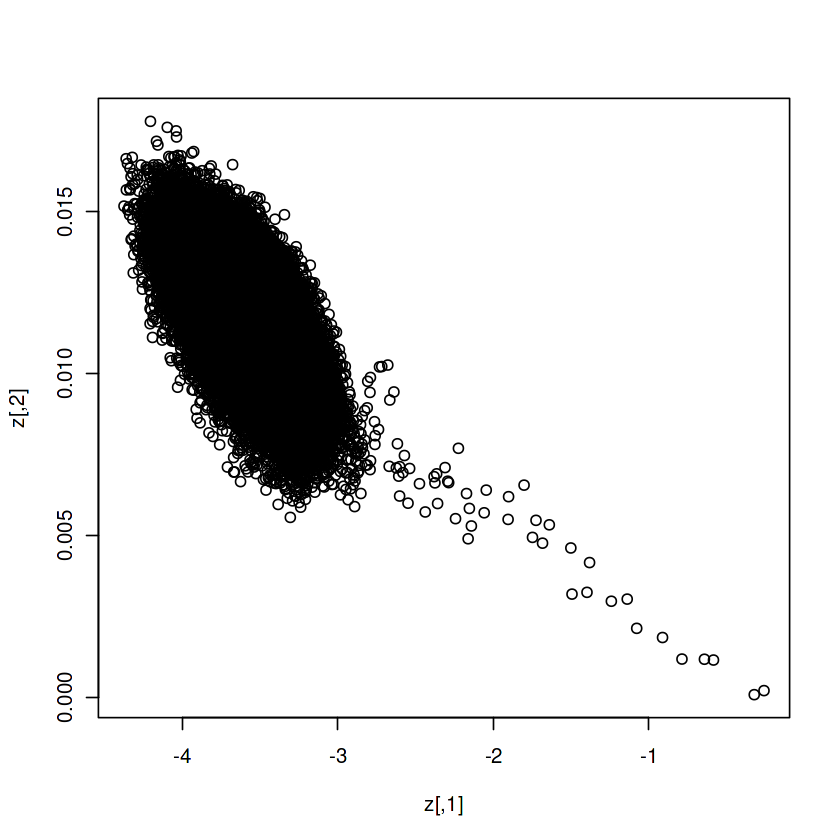

                mean          sd         2.5%         25%         50%
beta[1]  -3.58036790 0.215382772 -4.015813794 -3.72041122 -3.57279794
beta[2]   0.01158734 0.001506661  0.008612583  0.01058365  0.01159687
deviance 24.81886819 5.585646258 22.757819501 23.28677405 24.12186587
p[1]      0.02770640 0.006655622  0.017709014  0.02365108  0.02731039
p[2]      0.02927933 0.006808846  0.018929543  0.02511160  0.02889635
p[3]      0.03856470 0.007681067  0.026291723  0.03373748  0.03820368
p[4]      0.06300534 0.010122730  0.045643275  0.05631737  0.06254068
p[5]      0.13819670 0.021662774  0.099414835  0.12317852  0.13705374
p[6]      0.33837544 0.062455012  0.222164597  0.29476259  0.33644104
yf1[1]   10.83111111 4.153223832  4.000000000  8.00000000 11.00000000
yf1[2]    6.01761111 2.816130160  1.000000000  4.00000000  6.00000000
yf1[3]    6.01334444 2.690485731  2.000000000  4.00000000  6.00000000
yf1[4]    3.15138889 1.792086115  0.000000000  2.00000000  3.00000000
yf1[5]    4.84200000

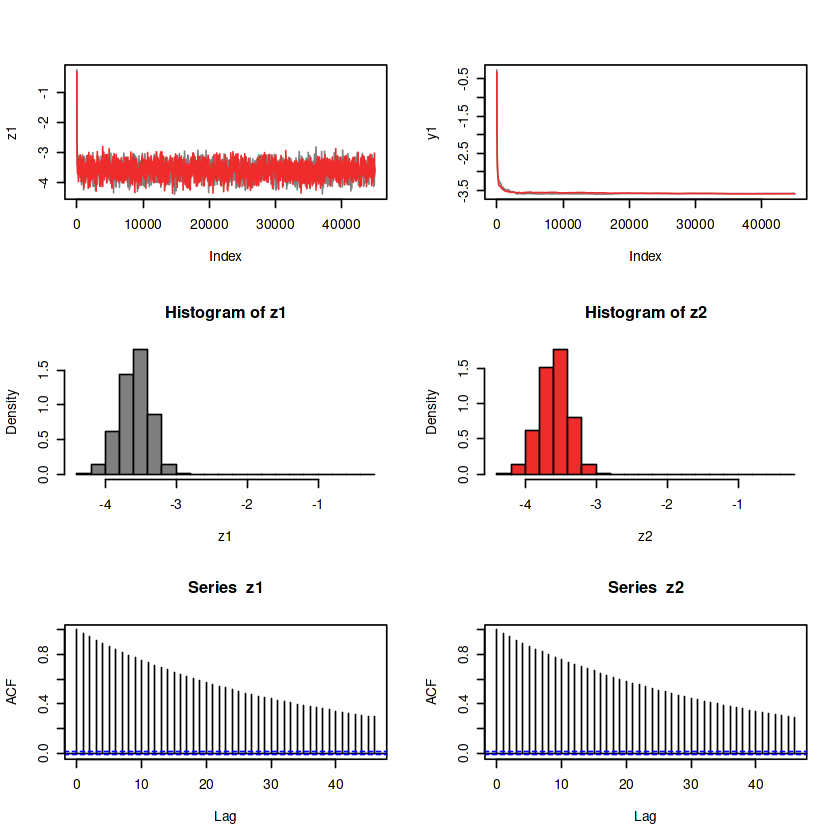

In [202]:
ej5b.sim$viewSpace()

ej5b.sim$graphConvergence()

ej5b.sim$summaryModel()

ej5b.sim$dicModelfunc()


## Checamos intervalos de predicción

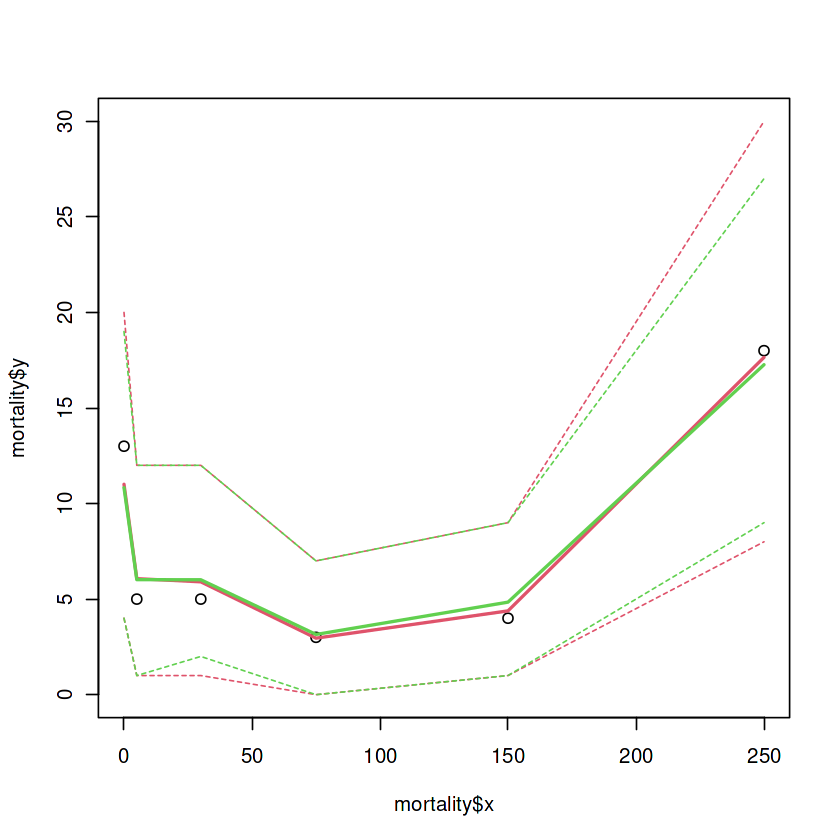

In [203]:
canvaMortalidad()

mortalidadGraf(ej5a.sim,col=2)

mortalidadGraf(ej5b.sim,col=3)

## Tercer modelo (probit)

CHECAR

Modelo

$y_{i}|\mu_{i} \sim \text{Bin}(\text{n}_{i},\text{p}_{i})$

Relación

$\mu_{i}=\text{n}_{i}\text{p}_{i}$

Liga logística

$\text{logit}(\text{p}_{i})=\beta_{1}+\beta_{2}*x_{i}$

Priors

$\beta_{j} \sim \text{Norm}(0,0.001)$

In [204]:
#corremos código
modelCode3 <- 'model
{
#Likelihood
for (i in 1:n) {
	y[i] ~ dbin(p[i],ne[i])
	mu[i]<-ne[i]*p[i]
#Liga logistica
#	logit(p[i])<-beta[1]+beta[2]*x[i]
#	eta[i]<-beta[1]+beta[2]*x[i]
#	p[i]<-exp(eta[i])/(1+exp(eta[i]))
#Liga probit
	p[i]<-phi(beta[1]+beta[2]*x[i])
#Liga log-log
#	eta[i]<-beta[1]+beta[2]*x[i]
#	p[i]<-exp(-exp(eta[i]))
#Liga clog-log
#	cloglog(p[i])<-beta[1]+beta[2]*x[i]
	}
#Priors 
for (j in 1:2) { beta[j] ~ dnorm(0,0.001) }
#Prediction 1
for (i in 1:n) { yf1[i] ~ dbin(p[i],ne[i]) }
#Prediction 2
#for (i in 1:m) { 
#	yf2[i] ~ dbin(pf[i],nef[i]) 
#	muf[i]<-nef[i]*pf[i]
#	logit(pf[i])<-beta[1]+beta[2]*xf[i]
#}
	yf2 ~ dbin(pf,nef) 
	muf<-nef*pf
#	logit(pf)<-beta[1]+beta[2]*xf
#	pf<-phi(beta[1]+beta[2]*xf)
#	etaf<-beta[1]+beta[2]*xf
#	pf<-exp(-exp(etaf))
	cloglog(pf)<-beta[1]+beta[2]*xf	
}'

ej5b.sim2 <- jagsModel$new(data, inits, parsbc, modelCode3, n.thin=1, n.iter=50000, n.burnin=5000)

ej5b.sim2$runJagsModel()

Warning message in jags.model(model.file, data = data, inits = init.values, n.chains = n.chains, :
“Unused variable "m" in data”


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 6
   Unobserved stochastic nodes: 9
   Total graph size: 60

Initializing model



## Verificamos convergencia

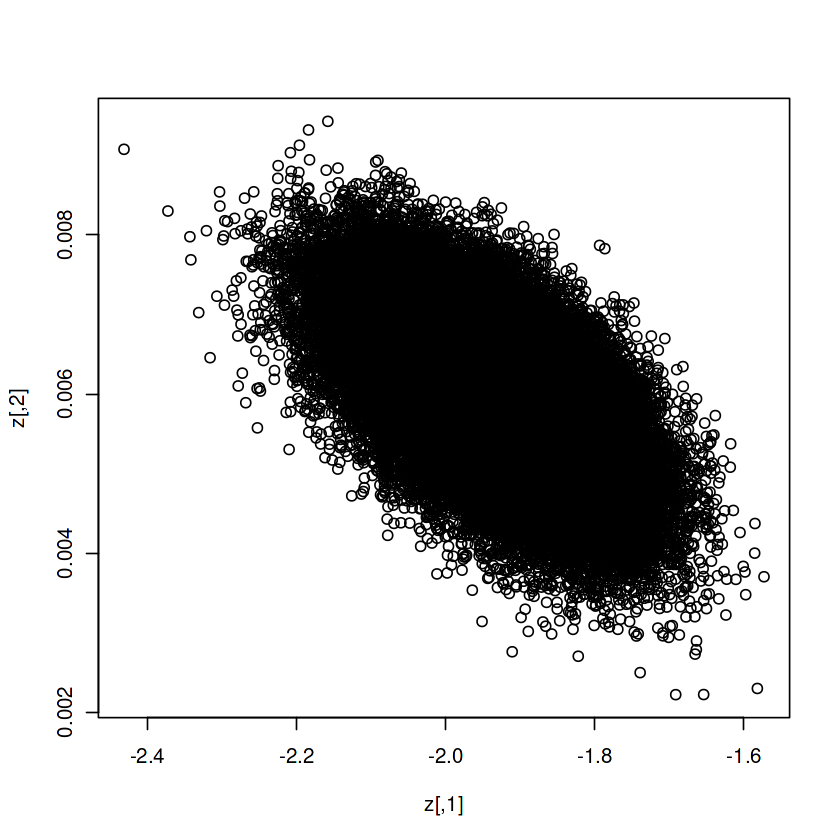

                 mean           sd         2.5%          25%         50%
beta[1]  -1.935191950 0.0927007700 -2.121835920 -1.996535765 -1.93346059
beta[2]   0.005958623 0.0008036699  0.004378142  0.005416568  0.00595941
deviance 25.227046794 2.0040818700 23.273310411 23.801802892 24.60593483
p[1]      0.026991702 0.0057411704  0.016925760  0.022937818  0.02658974
p[2]      0.028868286 0.0059216198  0.018423287  0.024687699  0.02848265
p[3]      0.039997962 0.0069430168  0.027413966  0.035154215  0.03961681
p[4]      0.068896161 0.0099908944  0.050604808  0.061915735  0.06847965
p[5]      0.150061134 0.0233447444  0.107239550  0.133780348  0.14903381
p[6]      0.330129838 0.0590110442  0.219618337  0.289123668  0.32847399
yf1[1]   10.531644444 3.9078171623  4.000000000  8.000000000 10.00000000
yf1[2]    5.913200000 2.6901820580  1.000000000  4.000000000  6.00000000
yf1[3]    6.251655556 2.6808506948  2.000000000  4.000000000  6.00000000
yf1[4]    3.437866667 1.8547476333  0.000000000  2.

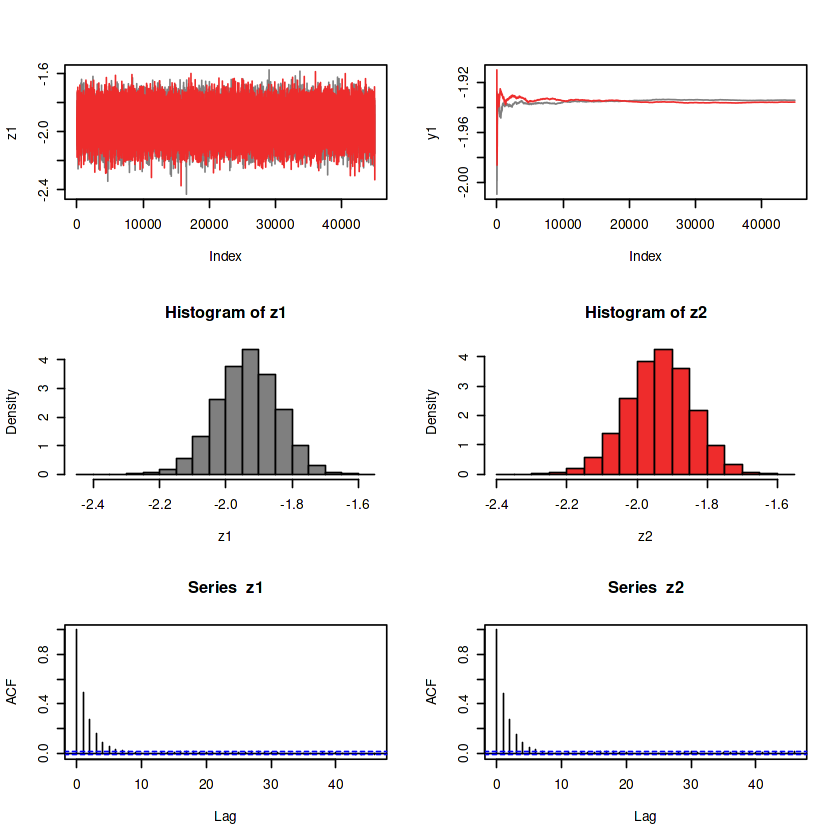

In [205]:
ej5b.sim2$viewSpace()

ej5b.sim2$graphConvergence()

ej5b.sim2$summaryModel()

ej5b.sim2$dicModelfunc()


## Checamos intervalos de predicción

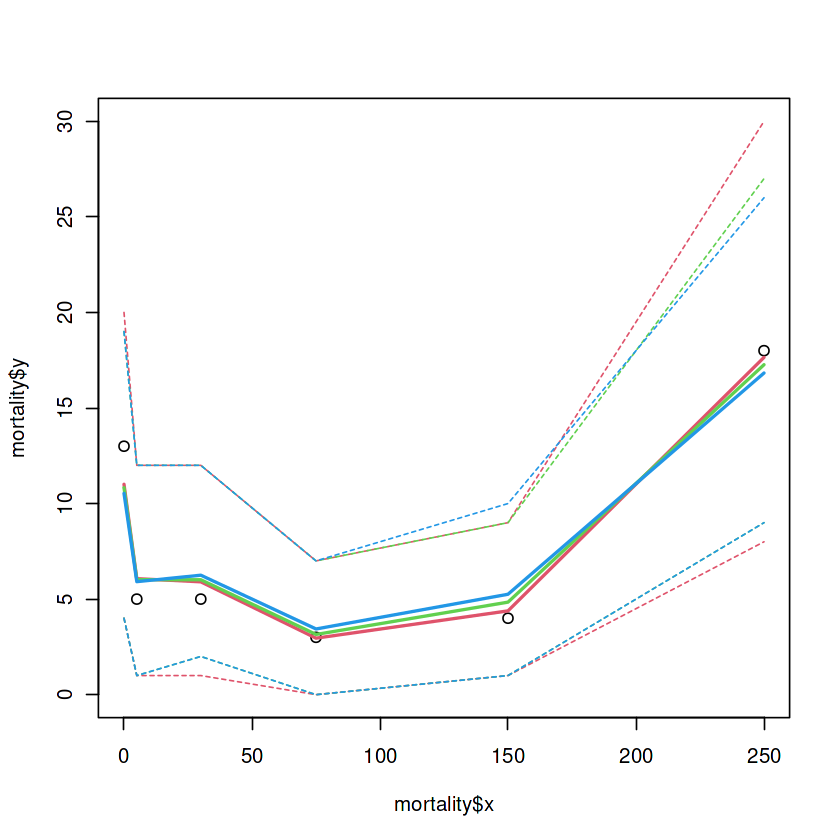

In [206]:
canvaMortalidad()

mortalidadGraf(ej5a.sim,col=2)

mortalidadGraf(ej5b.sim,col=3)

mortalidadGraf(ej5b.sim2,col=4)

## Cuarto modelo (log-log)

CHECAR

Modelo

$y_{i}|\mu_{i} \sim \text{Bin}(\text{n}_{i},\text{p}_{i})$

Relación

$\mu_{i}=\text{n}_{i}\text{p}_{i}$

Liga logística

$\text{logit}(\text{p}_{i})=\beta_{1}+\beta_{2}*x_{i}$

Priors

$\beta_{j} \sim \text{Norm}(0,0.001)$

In [207]:
#corremos código
modelCode4 <- 'model
{
#Likelihood
for (i in 1:n) {
	y[i] ~ dbin(p[i],ne[i])
	mu[i]<-ne[i]*p[i]
#Liga logistica
#	logit(p[i])<-beta[1]+beta[2]*x[i]
#	eta[i]<-beta[1]+beta[2]*x[i]
#	p[i]<-exp(eta[i])/(1+exp(eta[i]))
#Liga probit
#	p[i]<-phi(beta[1]+beta[2]*x[i])
#Liga log-log
	eta[i]<-beta[1]+beta[2]*x[i]
	p[i]<-exp(-exp(eta[i]))
#Liga clog-log
#	cloglog(p[i])<-beta[1]+beta[2]*x[i]
	}
#Priors 
for (j in 1:2) { beta[j] ~ dnorm(0,0.001) }
#Prediction 1
for (i in 1:n) { yf1[i] ~ dbin(p[i],ne[i]) }
#Prediction 2
#for (i in 1:m) { 
#	yf2[i] ~ dbin(pf[i],nef[i]) 
#	muf[i]<-nef[i]*pf[i]
#	logit(pf[i])<-beta[1]+beta[2]*xf[i]
#}
	yf2 ~ dbin(pf,nef) 
	muf<-nef*pf
#	logit(pf)<-beta[1]+beta[2]*xf
#	pf<-phi(beta[1]+beta[2]*xf)
#	etaf<-beta[1]+beta[2]*xf
#	pf<-exp(-exp(etaf))
	cloglog(pf)<-beta[1]+beta[2]*xf	
}'


ej5b.sim3 <- jagsModel$new(data, inits, parsbc, modelCode4, n.thin=1, n.iter=50000, n.burnin=5000)

ej5b.sim3$runJagsModel()



Warning message in jags.model(model.file, data = data, inits = init.values, n.chains = n.chains, :
“Unused variable "m" in data”


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 6
   Unobserved stochastic nodes: 9
   Total graph size: 72

Initializing model



## Checamos convergencia

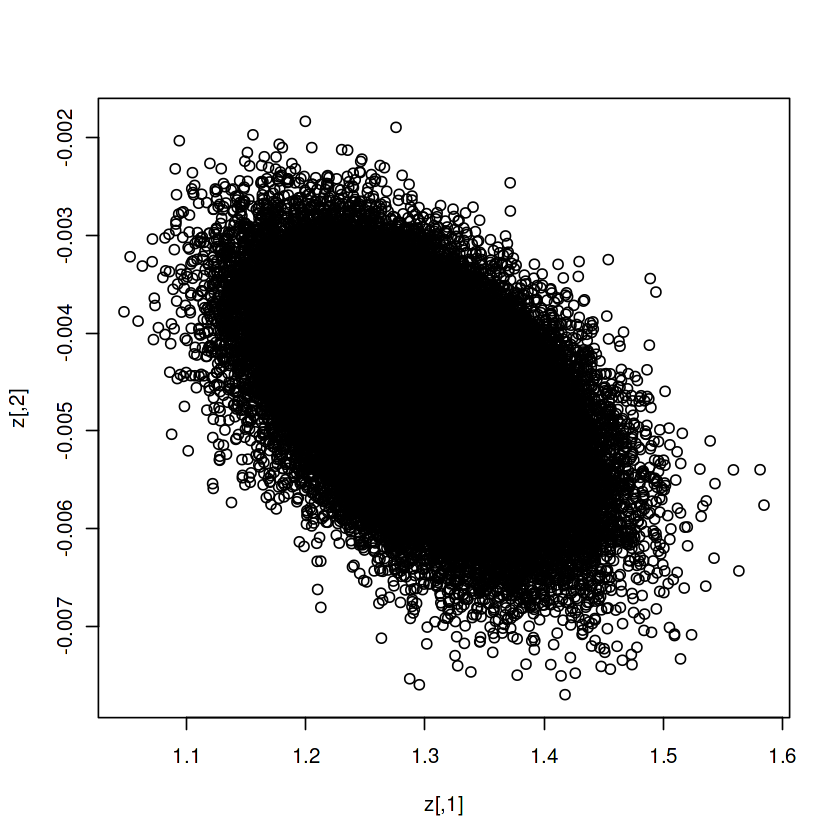

                 mean           sd         2.5%          25%          50%
beta[1]   1.294131339 0.0603798069  1.177046682  1.253252338  1.293407834
beta[2]  -0.004613159 0.0007001674 -0.006009981 -0.005077587 -0.004602691
deviance 26.040784577 2.0198589773 24.084520755 24.606322535 25.420794029
p[1]      0.026504529 0.0057812852  0.016370075  0.022419444  0.026116510
p[2]      0.028751427 0.0059630565  0.018213490  0.024549050  0.028368254
p[3]      0.042144021 0.0070693843  0.029292551  0.037204145  0.041782449
p[4]      0.076206186 0.0111785792  0.055880788  0.068424091  0.075709563
p[5]      0.162056873 0.0269236322  0.113349473  0.143222704  0.160619369
p[6]      0.316889635 0.0554991477  0.212845402  0.278372018  0.315287739
yf1[1]   10.351944444 3.9024413851  4.000000000  8.000000000 10.000000000
yf1[2]    5.892800000 2.6917466034  1.000000000  4.000000000  6.000000000
yf1[3]    6.575400000 2.7368672806  2.000000000  5.000000000  6.000000000
yf1[4]    3.809377778 1.9615230271  1.

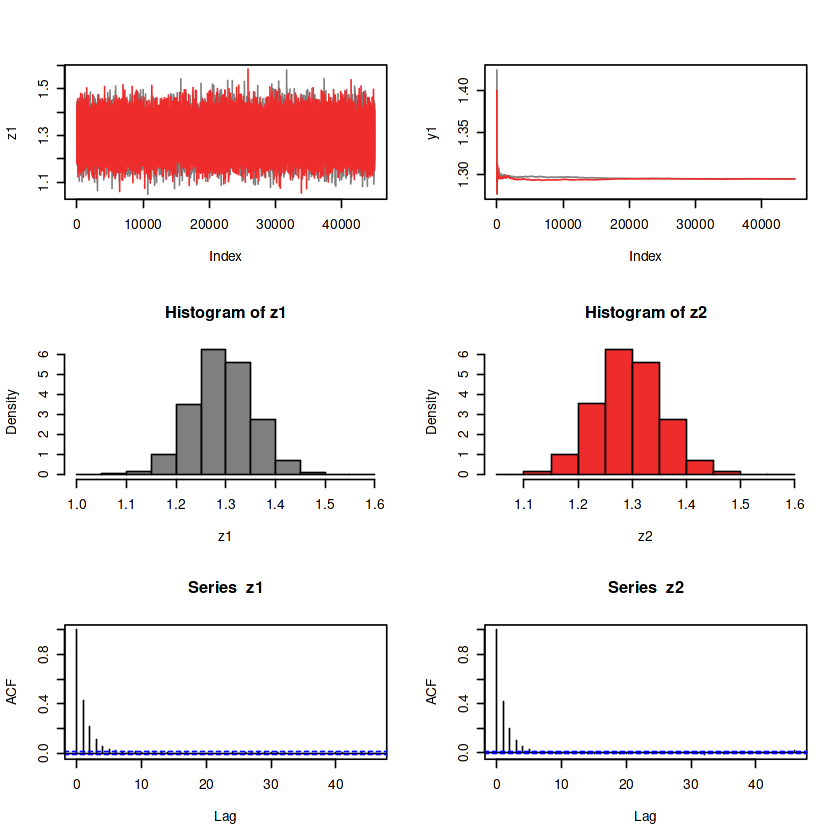

In [208]:
ej5b.sim3$viewSpace()

ej5b.sim3$graphConvergence()

ej5b.sim3$summaryModel()

ej5b.sim3$dicModelfunc()


## Checamos intervalos de predicción

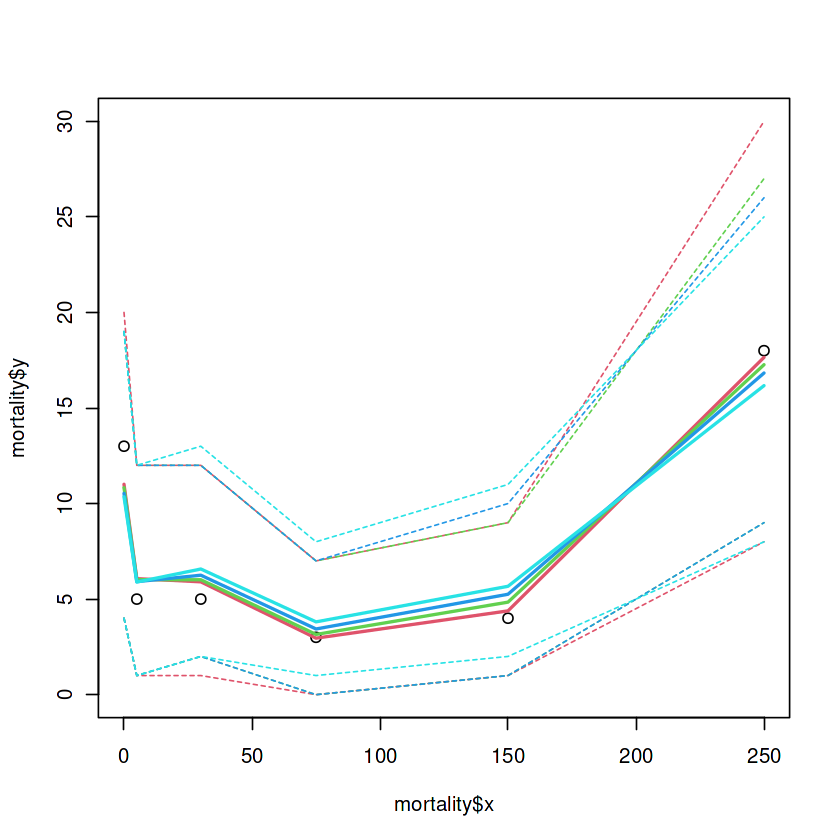

In [209]:
canvaMortalidad()

mortalidadGraf(ej5a.sim,col=2)

mortalidadGraf(ej5b.sim,col=3)

mortalidadGraf(ej5b.sim2,col=4)

mortalidadGraf(ej5b.sim3,col=5)

## Quinto modelo (clog-log)

CHECAR

Modelo

$y_{i}|\mu_{i} \sim \text{Bin}(\text{n}_{i},\text{p}_{i})$

Relación

$\mu_{i}=\text{n}_{i}\text{p}_{i}$

Liga logística

$\text{logit}(\text{p}_{i})=\beta_{1}+\beta_{2}*x_{i}$

Priors

$\beta_{j} \sim \text{Norm}(0,0.001)$

In [210]:
#corremos código
modelCode5 <- 'model
{
#Likelihood
for (i in 1:n) {
	y[i] ~ dbin(p[i],ne[i])
	mu[i]<-ne[i]*p[i]
#Liga logistica
#	logit(p[i])<-beta[1]+beta[2]*x[i]
#	eta[i]<-beta[1]+beta[2]*x[i]
#	p[i]<-exp(eta[i])/(1+exp(eta[i]))
#Liga probit
#	p[i]<-phi(beta[1]+beta[2]*x[i])
#Liga log-log
#	eta[i]<-beta[1]+beta[2]*x[i]
#	p[i]<-exp(-exp(eta[i]))
#Liga clog-log
	cloglog(p[i])<-beta[1]+beta[2]*x[i]
	}
#Priors 
for (j in 1:2) { beta[j] ~ dnorm(0,0.001) }
#Prediction 1
for (i in 1:n) { yf1[i] ~ dbin(p[i],ne[i]) }
#Prediction 2
#for (i in 1:m) { 
#	yf2[i] ~ dbin(pf[i],nef[i]) 
#	muf[i]<-nef[i]*pf[i]
#	logit(pf[i])<-beta[1]+beta[2]*xf[i]
#}
	yf2 ~ dbin(pf,nef) 
	muf<-nef*pf
#	logit(pf)<-beta[1]+beta[2]*xf
#	pf<-phi(beta[1]+beta[2]*xf)
#	etaf<-beta[1]+beta[2]*xf
#	pf<-exp(-exp(etaf))
	cloglog(pf)<-beta[1]+beta[2]*xf	
}'

ej5b.sim4 <- jagsModel$new(data, inits, parsbc, modelCode5, n.thin=1, n.iter=50000, n.burnin=5000)

ej5b.sim4$runJagsModel()


Warning message in jags.model(model.file, data = data, inits = init.values, n.chains = n.chains, :
“Unused variable "m" in data”


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 6
   Unobserved stochastic nodes: 9
   Total graph size: 60

Initializing model



## Checamos convergencia

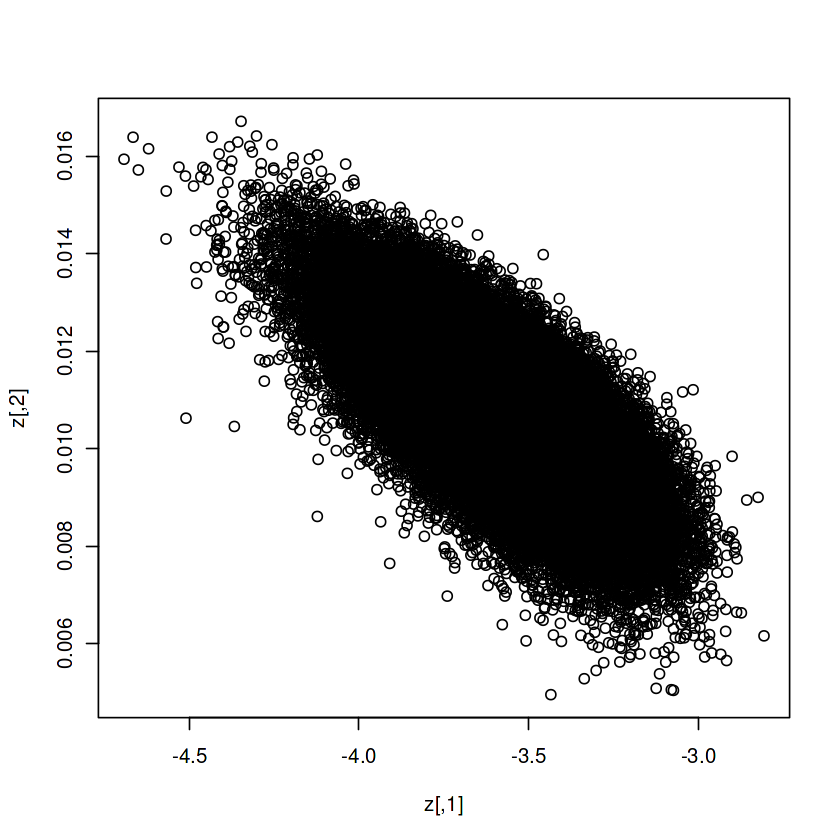

                mean          sd         2.5%          25%         50%
beta[1]  -3.58923677 0.210365553 -4.017762232 -3.726480753 -3.58331051
beta[2]   0.01080508 0.001325817  0.008161116  0.009924712  0.01081779
deviance 24.58422644 2.054634643 22.609917065 23.134274465 23.95128007
p[1]      0.02781782 0.005720293  0.017832274  0.023789873  0.02740115
p[2]      0.02931128 0.005887252  0.018989377  0.025169506  0.02889930
p[3]      0.03806952 0.006807321  0.025880797  0.033310895  0.03766357
p[4]      0.06087916 0.009102865  0.044204084  0.054550636  0.06047796
p[5]      0.13159475 0.018760753  0.096919600  0.118599025  0.13091757
p[6]      0.34160516 0.062747662  0.225023241  0.297988334  0.33958840
yf1[1]   10.86717778 3.933832904  4.000000000  8.000000000 11.00000000
yf1[2]    6.00944444 2.705568932  1.000000000  4.000000000  6.00000000
yf1[3]    5.93081111 2.604310408  2.000000000  4.000000000  6.00000000
yf1[4]    3.04086667 1.749186325  0.000000000  2.000000000  3.00000000
yf1[5]

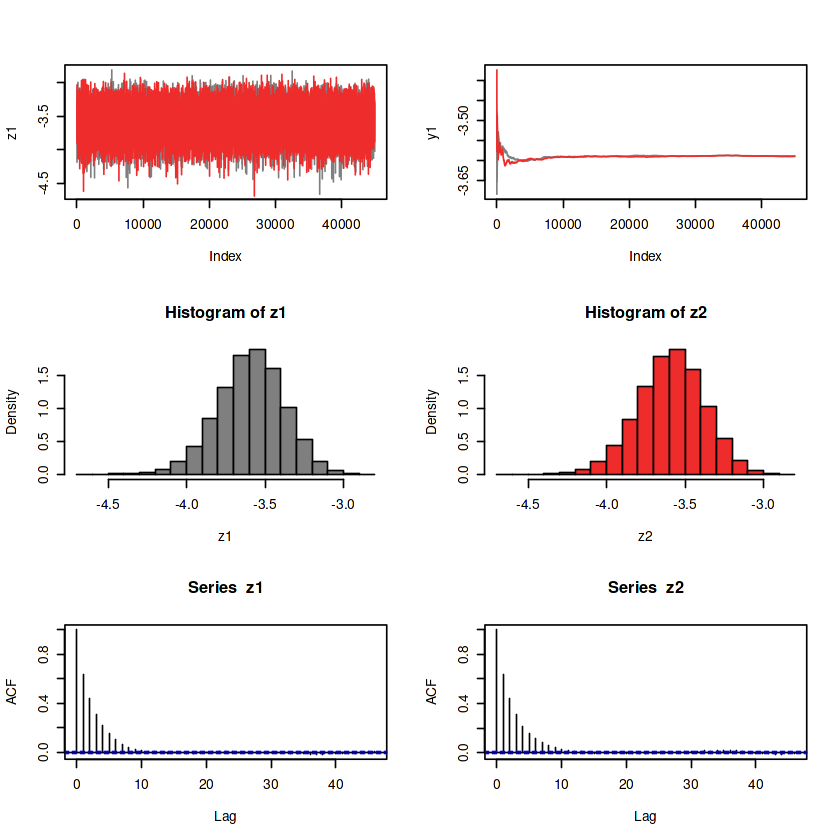

In [211]:
ej5b.sim4$viewSpace()

ej5b.sim4$graphConvergence()

ej5b.sim4$summaryModel()

ej5b.sim4$dicModelfunc()

## Checamos intervalos de predicción

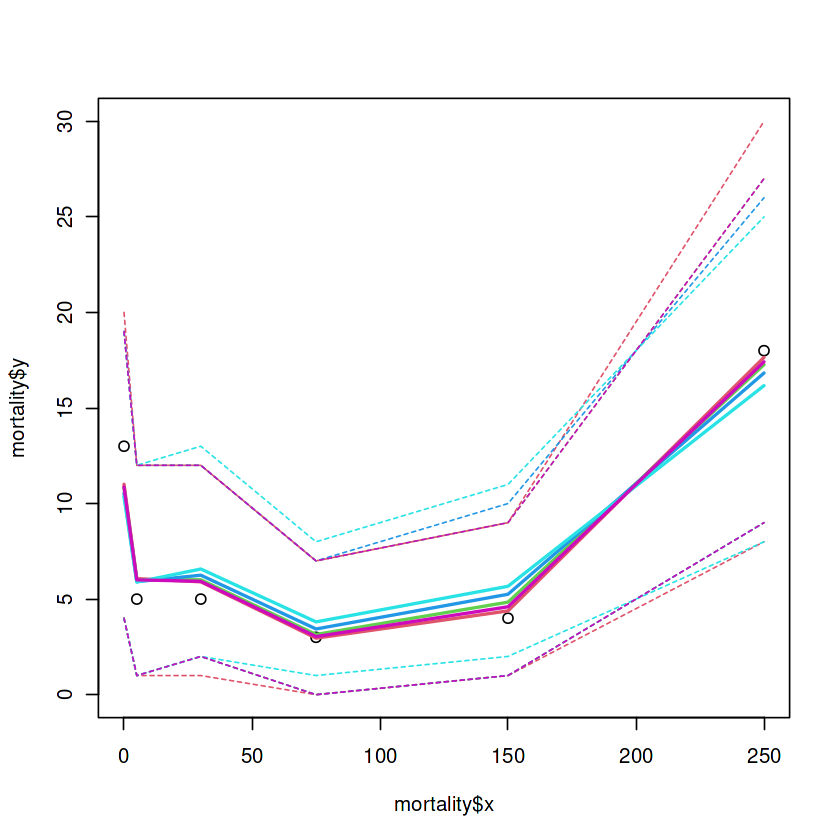

In [212]:
canvaMortalidad()

mortalidadGraf(ej5a.sim,col=2)

mortalidadGraf(ej5b.sim,col=3)

mortalidadGraf(ej5b.sim2,col=4)

mortalidadGraf(ej5b.sim3,col=5)

mortalidadGraf(ej5b.sim4,col=6)

## Sexto modelo

CHECAR

Modelo

$y_{i}|\mu_{i} \sim \text{Bin}(\text{n}_{i},\text{p}_{i})$

Relación

$\mu_{i}=\text{n}_{i}\text{p}_{i}$

Liga logística

$\text{logit}(\text{p}_{i})=\beta_{1}+\beta_{2}*x_{i}$

Priors

$\beta_{j} \sim \text{Norm}(0,0.001)$

In [213]:
#corremos código
modelCode6 <- 'model
{
#Likelihood
for (i in 1:n) {
	y[i] ~ dnegbin(p[i],ne[i])
	mu[i]<-ne[i]*lambda[i]
	lambda[i]<-(1-p[i])/p[i]
	eta[i]<-beta[1]+beta[2]*x[i]
#	logit(1-p[i])<-eta[i]
	p[i]<-1/(1+exp(eta[i]))
	}
#Priors 
for (j in 1:2) { beta[j] ~ dnorm(0,0.001) }
#Prediction 1
for (i in 1:n) { yf1[i] ~ dnegbin(p[i],ne[i]) }
#Prediction 2
#for (i in 1:m) { 
#	yf2[i] ~ dnegbin(pf[i],nef[i]) 
#	etaf[i]<-beta[1]+beta[2]*xf[i]
#	pf[i]<-1/(1+exp(etaf[i])
#}
	yf2 ~ dnegbin(pf,nef) 
	etaf<-beta[1]+beta[2]*xf
	pf<-1/(1+exp(etaf))
}'

ej5c.sim <- jagsModel$new(data, inits, parsbc, modelCode6, n.thin=1, n.iter=50000, n.burnin=5000)

ej5c.sim$runJagsModel()


Warning message in jags.model(model.file, data = data, inits = init.values, n.chains = n.chains, :
“Unused variable "m" in data”


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 6
   Unobserved stochastic nodes: 9
   Total graph size: 86

Initializing model



## Checamos convergencia

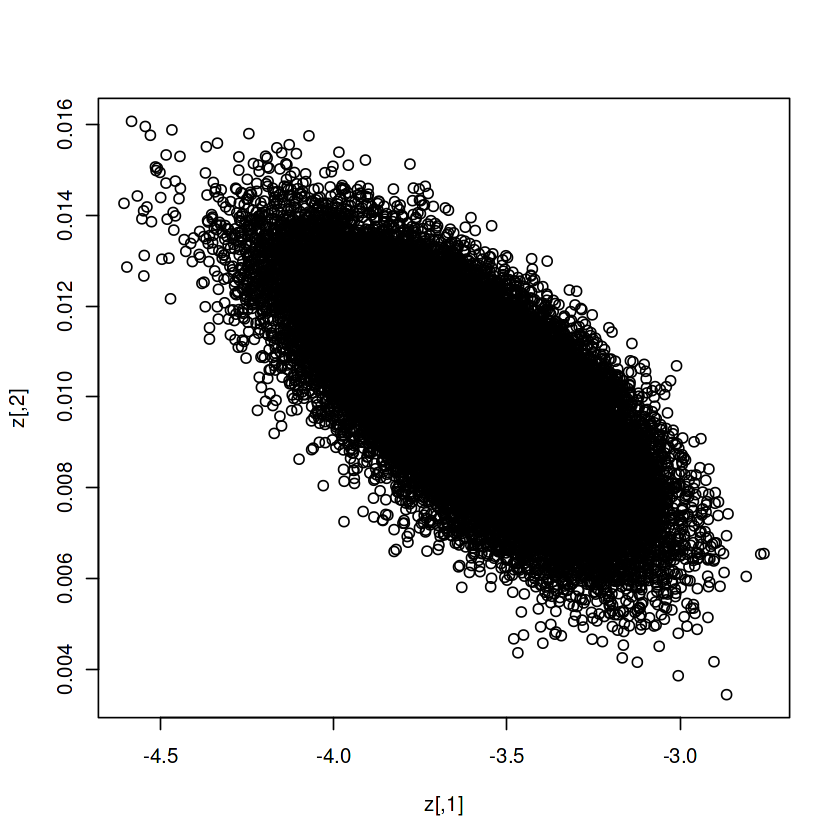

                mean          sd         2.5%          25%         50%
beta[1]  -3.58906820 0.212391815 -4.028211299 -3.727435806 -3.58226444
beta[2]   0.01001704 0.001429220  0.007222336  0.009059245  0.01001741
deviance 25.65630024 2.012282931 23.700568711 24.226147604 25.03763943
p[1]      0.97256284 0.005607681  0.960587616  0.969023741  0.97293996
p[2]      0.97122194 0.005740792  0.959019662  0.967592279  0.97158708
p[3]      0.96348127 0.006474696  0.949854471  0.959345175  0.96383474
p[4]      0.94409211 0.008386776  0.926624621  0.938692894  0.94449956
p[5]      0.88848076 0.016780104  0.853564580  0.877635309  0.88933547
p[6]      0.74422513 0.049262801  0.642280151  0.711806270  0.74626713
yf1[1]   11.04500000 4.082241234  4.000000000  8.000000000 11.00000000
yf1[2]    6.08331111 2.794083313  1.000000000  4.000000000  6.00000000
yf1[3]    5.91272222 2.699664015  1.000000000  4.000000000  6.00000000
yf1[4]    2.95865556 1.838678686  0.000000000  2.000000000  3.00000000
yf1[5]

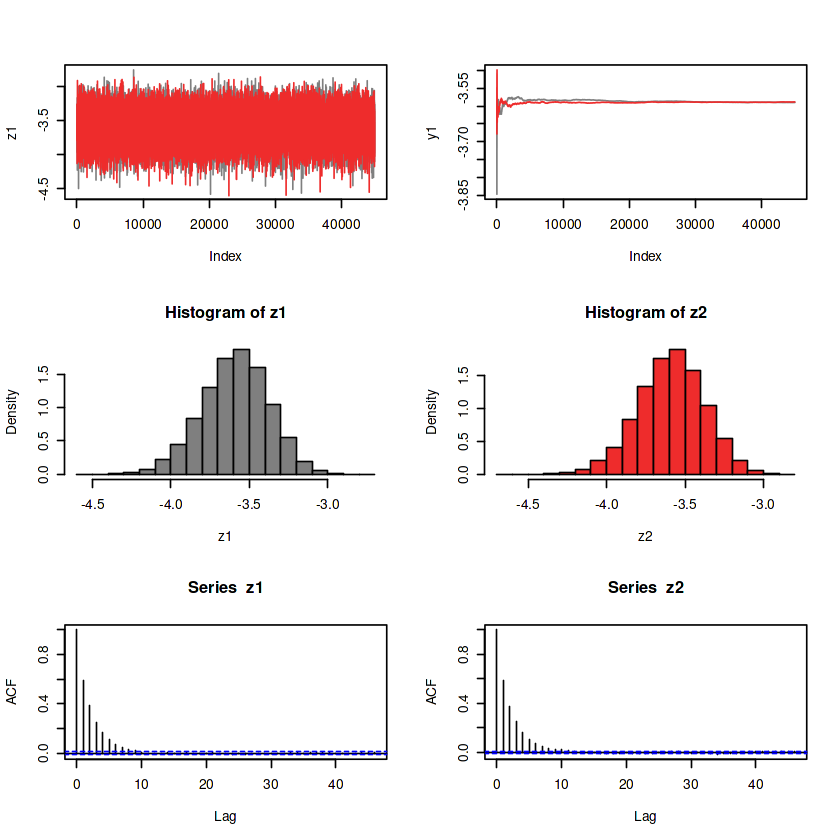

In [214]:
ej5c.sim$viewSpace()

ej5c.sim$graphConvergence()

ej5c.sim$summaryModel()

ej5c.sim$dicModelfunc()

## Checamos intervalos de predicción

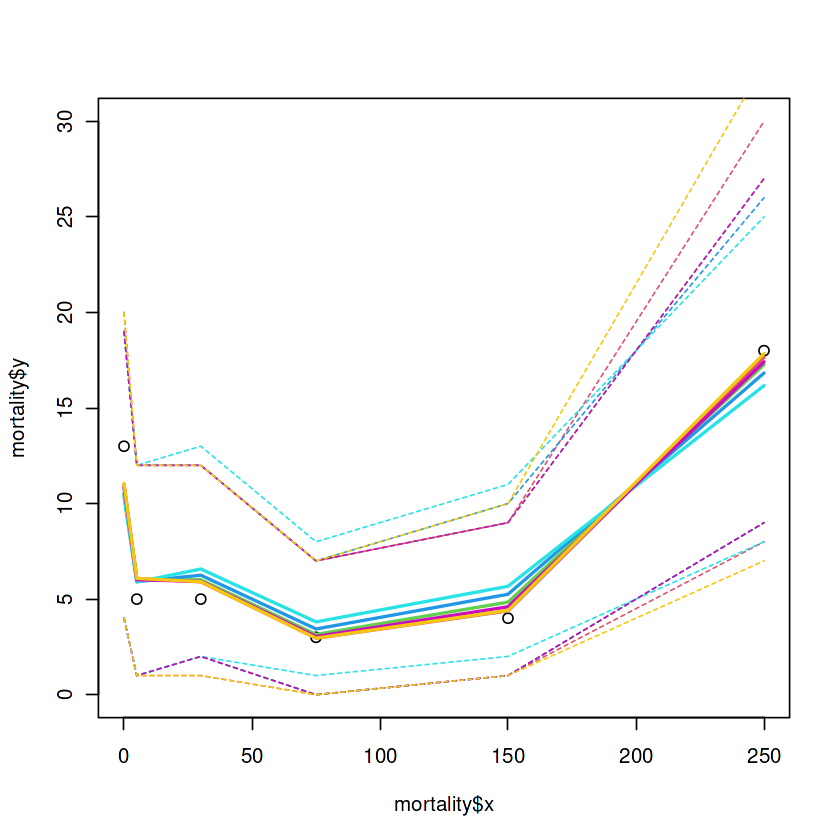

In [215]:
canvaMortalidad()

mortalidadGraf(ej5a.sim,col=2)

mortalidadGraf(ej5b.sim,col=3)

mortalidadGraf(ej5b.sim2,col=4)

mortalidadGraf(ej5b.sim3,col=5)

mortalidadGraf(ej5b.sim4,col=6)

mortalidadGraf(ej5c.sim,col=7)

## Séptimo modelo

CHECAR

Modelo

$y_{i}|\mu_{i} \sim \text{Bin}(\text{n}_{i},\text{p}_{i})$

Relación

$\mu_{i}=\text{n}_{i}\text{p}_{i}$

Liga logística

$\text{logit}(\text{p}_{i})=\beta_{1}+\beta_{2}*x_{i}$

Priors

$\beta_{j} \sim \text{Norm}(0,0.001)$

In [216]:
#corremos código
modelCode7 <- 'model
{
#Likelihood
for (i in 1:n) {
	y[i] ~ dbeta(a[i],b[i])
	a[i]<-phy*mu[i]
	b[i]<-phy*(1-mu[i])
#	logit(mu[i])<-beta[1]+beta[2]*x[i]
	eta[i]<-beta[1]+beta[2]*x[i]
	mu[i]<-exp(eta[i])/(1+exp(eta[i]))
	}
#Priors 
phy ~ dgamma(0.01,0.01)
for (j in 1:2) { beta[j] ~ dnorm(0,0.001) }
#Prediction 1
for (i in 1:n) { yf1[i] ~ dbeta(a[i],b[i]) }
#Prediction 2
	yf2 ~ dbeta(af,bf) 
	af<-phy*muf
	bf<-phy*(1-muf)
	logit(muf)<-beta[1]+beta[2]*xf
}'

ej5d.sim <- jagsModel$new(data2, inits2, parsd, modelCode7, n.thin=5, n.iter=10000, n.burnin=1000)

ej5d.sim$runJagsModel()

Warning message in jags.model(model.file, data = data, inits = init.values, n.chains = n.chains, :
“Unused variable "m" in data”


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 6
   Unobserved stochastic nodes: 10
   Total graph size: 82

Initializing model



## Checamos convergencia

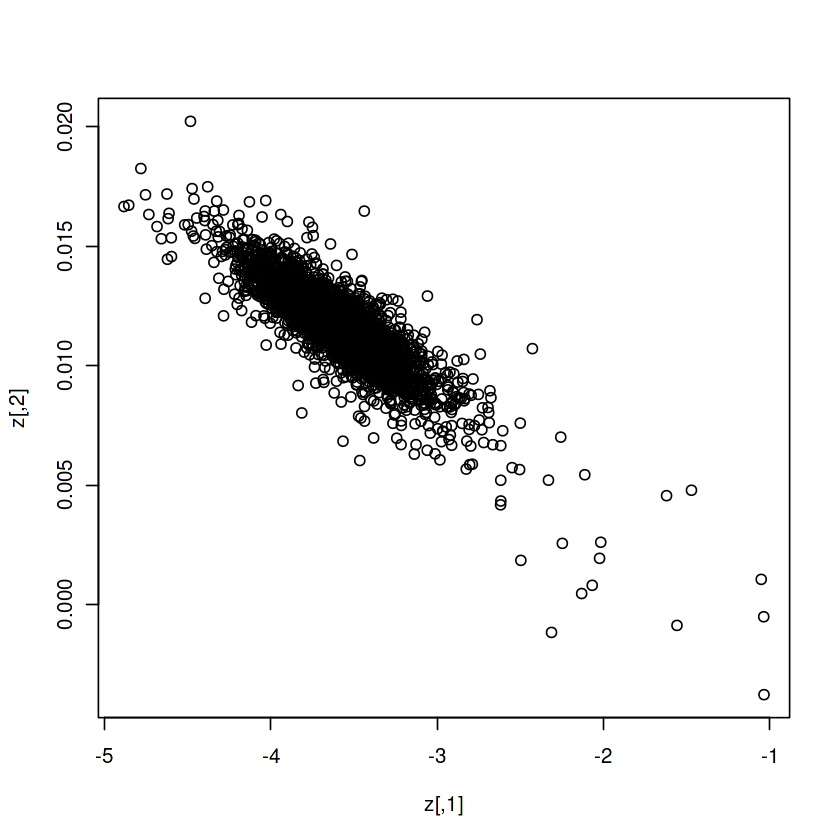

                 mean           sd          2.5%          25%          50%
beta[1]   -3.60275523 3.061487e-01  -4.159563095  -3.78098200  -3.61268878
beta[2]    0.01171812 1.695896e-03   0.008354458   0.01086376   0.01180700
deviance -31.82756689 4.351637e+00 -38.239290523 -34.96079787 -32.42604851
phy      154.09151128 1.030687e+02  22.928829193  78.31813487 132.90499955
yf1[1]     0.02808091 2.209168e-02   0.002835338   0.01496908   0.02373228
yf1[2]     0.02940815 2.344553e-02   0.003241847   0.01655029   0.02509437
yf1[3]     0.03766355 2.602567e-02   0.006355348   0.02354130   0.03336500
yf1[4]     0.06238247 2.981192e-02   0.017760116   0.04501405   0.05822193
yf1[5]     0.13668526 4.178644e-02   0.067412559   0.11202962   0.13339266
yf1[6]     0.33839914 6.813698e-02   0.203190765   0.29951237   0.33725237
yf2        0.22327578 5.432916e-02   0.127808592   0.19289877   0.22016912
                  75%        97.5%     Rhat n.eff
beta[1]   -3.44348929  -2.97282135 1.022755   360


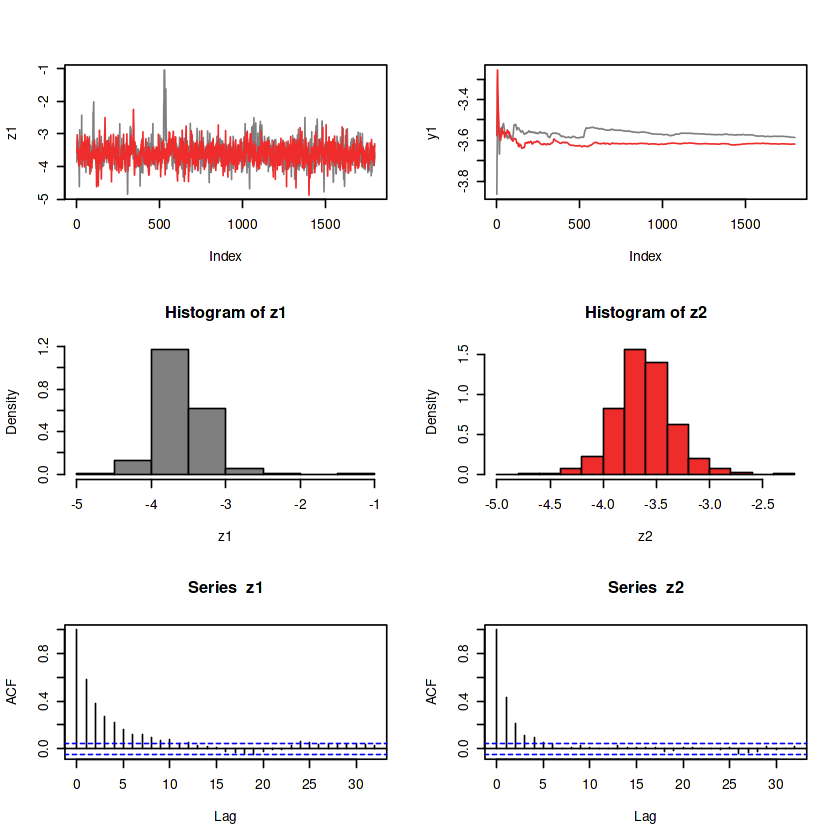

In [217]:
ej5d.sim$viewSpace()

ej5d.sim$graphConvergence()

ej5d.sim$summaryModel()

ej5d.sim$dicModelfunc()

## Checamos intervalos de predicción

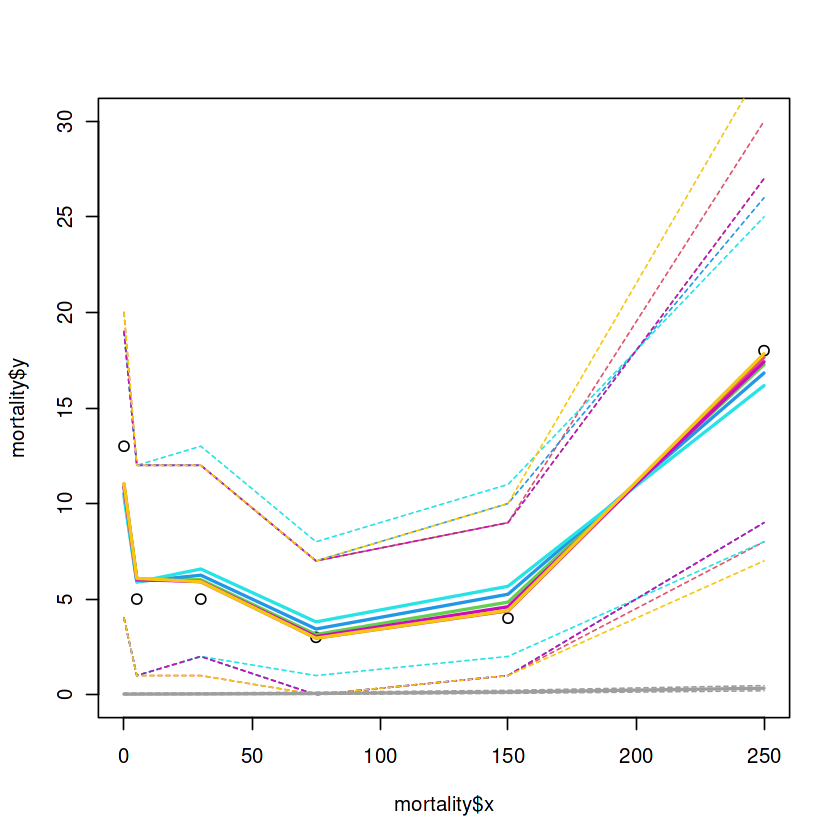

In [218]:
canvaMortalidad()

mortalidadGraf(ej5a.sim,col=2)

mortalidadGraf(ej5b.sim,col=3)

mortalidadGraf(ej5b.sim2,col=4)

mortalidadGraf(ej5b.sim3,col=5)

mortalidadGraf(ej5b.sim4,col=6)

mortalidadGraf(ej5c.sim,col=7)

mortalidadGraf(ej5d.sim,col=8)